In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft, fftshift
import os
import h5py
import random as rn
import cmath as cm
from statistics import mean
from matplotlib import rcParams
from scipy.io import savemat, loadmat
import nitime.timeseries as nts
import time
from scipy.io import savemat, loadmat
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, SGD
import torch.nn.functional as func
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from statistics import mean
from torch.nn import MSELoss, L1Loss, SmoothL1Loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
import warnings
from tqdm import tqdm

## **CNN-SR Unsupervised Learning Training**

In [3]:
class Model(nn.Module):
    '''ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> FC -> F0 and Phs'''
    def __init__(self):
        '''Define model modules.'''
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(1, 2, 128, 1, 64)
        self.bn1 = nn.BatchNorm1d(num_features=2)
        self.conv2 = nn.Conv1d(2, 4, 128, 1, 64)
        self.bn2 = nn.BatchNorm1d(num_features=4)
        self.conv3 = nn.Conv1d(4, 8, 128, 1, 64)
        self.bn3 = nn.BatchNorm1d(num_features=8)
        self.conv4 = nn.Conv1d(8, 16, 128, 1, 64)
        self.bn4 = nn.BatchNorm1d(num_features=16)
        self.fc1 = nn.Linear(128 * 1 * 16, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool1d(x, 2, 2)
        x = x.view(-1, 128 * 1 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

JETSR_L = Model()

cuda = torch.cuda.is_available()
print("GPU available:", cuda)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# If GPU available, move the model to GPU.
if cuda:
    JETSR_L.to(device)

torch.manual_seed(1102)
np.random.seed(1102)

print(JETSR_L)

GPU available: True
cuda:1
Model(
  (conv1): Conv1d(1, 2, kernel_size=(128,), stride=(1,), padding=(64,))
  (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(2, 4, kernel_size=(128,), stride=(1,), padding=(64,))
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(4, 8, kernel_size=(128,), stride=(1,), padding=(64,))
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(8, 16, kernel_size=(128,), stride=(1,), padding=(64,))
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)


In [4]:
# creating template
data_path='/media/sail/Elements/JET_CNN/DL-FPC/JET_SR_Input/'
PH_invivoData=loadmat(os.path.join(data_path, "PH_InVivoData.mat"))

FidsOFF = PH_invivoData['OFFdata'] 
FidsON = PH_invivoData['ONdata'] 

SR_FidsOFF = PH_invivoData['OFFdata_Gannet_SR'] 
SR_FidsON = PH_invivoData['ONdata_Gannet_SR'] 

Fids = np.concatenate((FidsOFF, FidsON), axis=1) 

Gannet_PH_invivoData=loadmat(os.path.join(data_path, "PH_InVivoData_Template.mat"))

OFFdata_Gannet_template=Gannet_PH_invivoData['OFFdata_Gannet_template']
ONdata_Gannet_template=Gannet_PH_invivoData['ONdata_Gannet_template']

#Apply artifical No offsets to in vivo data and prepare data for network
time = np.arange(2048)/2000
spectOffsetOFF = np.empty((len(FidsOFF[:,0,0]), len(FidsOFF[0,:,0]),len(FidsOFF[0,0,:])), dtype = np.complex_)
spectOffsetON = np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
FidsOffsetOFF = np.empty(spectOffsetOFF.shape, dtype = np.complex_)
FidsOffsetON = np.empty(spectOffsetON.shape, dtype = np.complex_)
spectOffsetOFFscale = np.empty((len(FidsOFF[:,0,0]), len(FidsOFF[0,:,0]),len(FidsOFF[0,0,:])), dtype = np.complex_)
spectOffsetONscale = np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
spectOFFscale = np.empty((len(FidsOFF[:,0,0]), len(FidsOFF[0,:,0]),len(FidsOFF[0,0,:])), dtype = np.complex_)
spectONscale = np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
spectOFF = np.empty((len(FidsOFF[:,0,0]), len(FidsOFF[0,:,0]),len(FidsOFF[0,0,:])), dtype = np.complex_)
spectON = np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

FidsOFF_template=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
FidsON_template=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

spectOFF_template=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
spectON_template=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

spectOFF_template_scaled=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
spectON_template_scaled=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

#######Gannet spectra#######
Gannet_spectOFF=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
Gannet_spectON=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

#######Gannet spectra scaled#######
Gannet_spectOFFscale=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
Gannet_spectONscale=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

#######Gannet Fids template#######
Gannet_FidsOFF_template=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
Gannet_FidsON_template=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

#######Gannet Spec template#######
Gannet_spectOFF_template=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
Gannet_spectON_template=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

Gannet_spectOFF_template_scaled=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)
Gannet_spectON_template_scaled=np.empty((len(FidsON[:,0,0]), len(FidsON[0,:,0]), len(FidsON[0,0,:])), dtype = np.complex_)

# generating scaled gannet offset spectra template
for kk in range(len(FidsON[0,:,0])):
    for mm in range(len(FidsON[0,0,:])):
        
        FidsOffsetOFF[:,kk,mm] = FidsOFF[:,kk,mm] 
        FidsOffsetON[:,kk,mm] = FidsON[:,kk,mm] 
        
        spectOffsetOFF[:,kk,mm] = np.squeeze(fftshift(fft(FidsOffsetOFF[:,kk,mm]))) 
        spectOffsetON[:,kk,mm] = np.squeeze(fftshift(fft(FidsOffsetON[:,kk,mm]))) 
        
        scaleOFF = np.max(np.squeeze(np.abs(spectOffsetOFF[:,kk,mm])))
        spectOffsetOFFscale[:,kk,mm] = spectOffsetOFF[:,kk,mm]/scaleOFF
        scaleON = np.max(np.squeeze(np.abs(spectOffsetON[:,kk,mm])))
        spectOffsetONscale[:,kk,mm] = spectOffsetON[:,kk,mm]/scaleON
        
        Gannet_spectOFF[:,kk,mm] = np.squeeze(fftshift(fft(OFFdata_Gannet_template[:,kk,mm]))) 
        Gannet_spectON[:,kk,mm] = np.squeeze(fftshift(fft(ONdata_Gannet_template[:,kk,mm])))
        
        GannetscaleOFF = np.max(np.squeeze(np.abs(Gannet_spectOFF[:,kk,mm])))
        Gannet_spectOFFscale[:,kk,mm] = Gannet_spectOFF[:,kk,mm]/GannetscaleOFF
        GannetscaleON = np.max(np.squeeze(np.abs(Gannet_spectON[:,kk,mm])))
        Gannet_spectONscale[:,kk,mm] = Gannet_spectON[:,kk,mm]/GannetscaleON

for kk in range(len(FidsON[0,:,0])):
    for mm in range(len(FidsON[0,0,:])):
        FidsOFF_template[:,kk,mm] = OFFdata_Gannet_template[:,kk,mm] 
        FidsON_template[:,kk,mm] = ONdata_Gannet_template[:,kk,mm] 
        
        spectOFF_template[:,kk,mm] = np.squeeze(fftshift(fft(FidsOFF_template[:,kk,mm]))) 
        spectON_template[:,kk,mm] = np.squeeze(fftshift(fft(FidsON_template[:,kk,mm]))) 
        
        scaleOFF = np.max(np.squeeze(np.abs(spectOFF_template[:,kk,mm])))
        spectOFF_template_scaled[:,kk,mm] = spectOFF_template[:,kk,mm]/scaleOFF
        scaleON = np.max(np.squeeze(np.abs(spectON_template[:,kk,mm])))
        spectON_template_scaled[:,kk,mm] = spectON_template[:,kk,mm]/scaleOFF

# generating input data
spectUnAlignedOFFscale=spectOffsetOFFscale
spectUnAlignedONscale=spectOffsetONscale

testDataOFF = np.real(spectUnAlignedOFFscale[512:-512,:,:]) 
testDataON = np.real(spectUnAlignedONscale[512:-512,:,:]) 

testDataOFF_template = np.real(spectOFF_template_scaled[512:-512,:,:]) 
testDataON_template = np.real(spectON_template_scaled[512:-512,:,:]) 

testDataInputOFF=np.concatenate((testDataOFF,testDataOFF_template),axis=0)
testDataInputON=np.concatenate((testDataON,testDataON_template),axis=0)

In [6]:
## Rearranging the data to input into model

Fids=np.array([])
FidsOffset=np.array([])
unaligned_aligned_spectra=np.array([])

for rep in range(testDataInputOFF.shape[1]): 
    for subject_OFF in range(testDataOFF.shape[2]): 
        if subject_OFF==0 and rep==0:
            unaligned_aligned_spectra=np.append(unaligned_aligned_spectra,testDataInputOFF[:,rep,subject_OFF])
            Fids=np.append(Fids, FidsOFF_template[:,rep,subject_OFF])
            FidsOffset=np.append(FidsOffset, FidsOffsetOFF[:,rep,subject_OFF])
            
        else: 
            unaligned_aligned_spectra=np.vstack((unaligned_aligned_spectra,testDataInputOFF[:,rep,subject_OFF]))
            Fids=np.vstack((Fids, FidsOFF_template[:,rep,subject_OFF]))
            FidsOffset=np.vstack((FidsOffset, FidsOffsetOFF[:,rep,subject_OFF]))

    for subject_ON in range(testDataON.shape[2]): 
        unaligned_aligned_spectra=np.vstack((unaligned_aligned_spectra,testDataInputON[:,rep,subject_ON]))
        Fids=np.vstack((Fids, FidsON_template[:,rep,subject_ON]))
        FidsOffset=np.vstack((FidsOffset, FidsOffsetON[:,rep,subject_ON]))

Real_aligned_fids=np.real(Fids)
Imag_aligned_fids=np.imag(Fids)

Real_unaligned_fids=np.real(FidsOffset)
Imag_unaligned_fids=np.imag(FidsOffset)

In [8]:
#### defining variables
time = np.arange(2048)/2000
time=np.expand_dims(np.transpose(time),axis=(1,2))
time= np.tile(time,[1,320,spectUnAlignedOFFscale.shape[2]])
time=time.reshape(2048,320*spectUnAlignedOFFscale.shape[2])
time=np.transpose(time)

# initializer
initializer=np.zeros(spectUnAlignedOFFscale.shape[2]*320)

# converting to tensor
unaligned_aligned_spectra=torch.from_numpy(unaligned_aligned_spectra).type(torch.FloatTensor).view(-1, 1, 2048)
Real_aligned_fids=torch.from_numpy(Real_aligned_fids).type(torch.FloatTensor).view(-1, 1, 2048)
Imag_aligned_fids=torch.from_numpy(Imag_aligned_fids).type(torch.FloatTensor).view(-1, 1, 2048)
Real_unaligned_fids=torch.from_numpy(Real_unaligned_fids).type(torch.FloatTensor).view(-1, 1, 2048)
Imag_unaligned_fids=torch.from_numpy(Imag_unaligned_fids).type(torch.FloatTensor).view(-1, 1, 2048)
initializer=torch.from_numpy(np.squeeze(initializer)).type(torch.FloatTensor)
time=torch.from_numpy(time).type(torch.FloatTensor).view(-1, 1, 2048)

In [9]:
# saving variables
data_path='/media/sail/Elements/JET_CNN/DL-FPC/JET_SR_Input/'
savemat(os.path.join(data_path, "PH_Unaligned_Aligned_spectra_NoOffset.mat"), {"PH_Unaligned_Aligned_spectra_NoOffset":unaligned_aligned_spectra})
savemat(os.path.join(data_path, "PH_Aligned_Imag_Fids_NoOffset.mat"), {"PH_Aligned_Imag_Fids_NoOffset":Imag_aligned_fids})
savemat(os.path.join(data_path, "PH_Unaligned_Real_Fids_NoOffset.mat"), {"PH_Unaligned_Real_Fids_NoOffset":Real_unaligned_fids})
savemat(os.path.join(data_path, "PH_Unaligned_Imag_Fids_NoOffset.mat"), {"PH_Unaligned_Imag_Fids_NoOffset":Imag_unaligned_fids})
savemat(os.path.join(data_path, "PH_Aligned_Real_Fids_NoOffset.mat"), {"PH_Aligned_Real_Fids_NoOffset":Real_aligned_fids})
savemat(os.path.join(data_path, "PH_Initializer_NoOffset.mat"), {"PH_Initializer_NoOffset":initializer})
savemat(os.path.join(data_path, "PH_Time_NoOffset.mat"), {"PH_Time_NoOffset":time})

In [10]:
# loading data
data_path='/media/sail/Elements/JET_CNN/DL-FPC/JET_SR_Input/'
unaligned_aligned_spectra = loadmat(os.path.join(data_path, "PH_Unaligned_Aligned_spectra_NoOffset.mat"))["PH_Unaligned_Aligned_spectra_NoOffset"]
Imag_aligned_fids = loadmat(os.path.join(data_path, "PH_Aligned_Imag_Fids_NoOffset.mat"))["PH_Aligned_Imag_Fids_NoOffset"]
Real_aligned_fids = loadmat(os.path.join(data_path, "PH_Aligned_Real_Fids_NoOffset.mat"))["PH_Aligned_Real_Fids_NoOffset"]
Imag_unaligned_fids = loadmat(os.path.join(data_path, "PH_Unaligned_Imag_Fids_NoOffset.mat"))["PH_Unaligned_Imag_Fids_NoOffset"]
Real_unaligned_fids = loadmat(os.path.join(data_path, "PH_Unaligned_Real_Fids_NoOffset.mat"))["PH_Unaligned_Real_Fids_NoOffset"]
initializer = loadmat(os.path.join(data_path, "PH_Initializer_NoOffset.mat"))["PH_Initializer_NoOffset"]
time = loadmat(os.path.join(data_path, "PH_Time_NoOffset.mat"))["PH_Time_NoOffset"]

In [16]:
#defining train data and train loader
batch_size_training=202
train_data = TensorDataset(unaligned_aligned_spectra1, Real_unaligned_fids, Imag_unaligned_fids, Real_aligned_fids, Imag_aligned_fids, \
                           time, initializer)
train_loader = DataLoader(train_data, batch_size = batch_size_training)


Training begins...


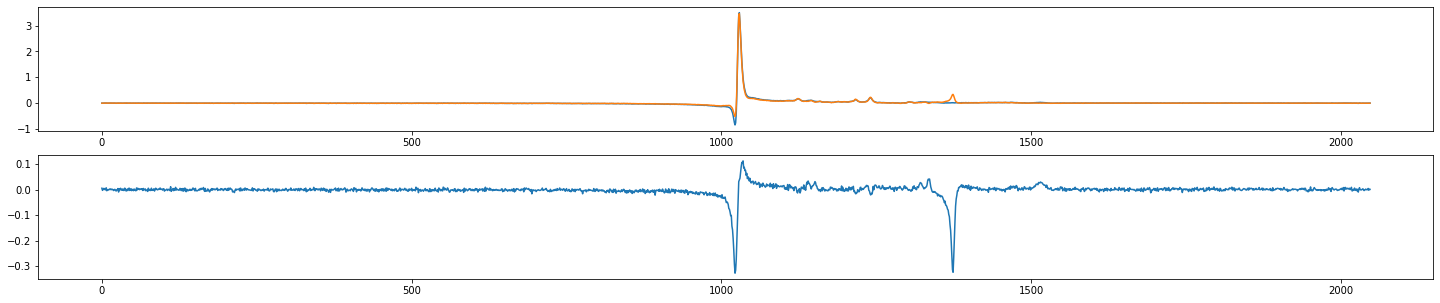

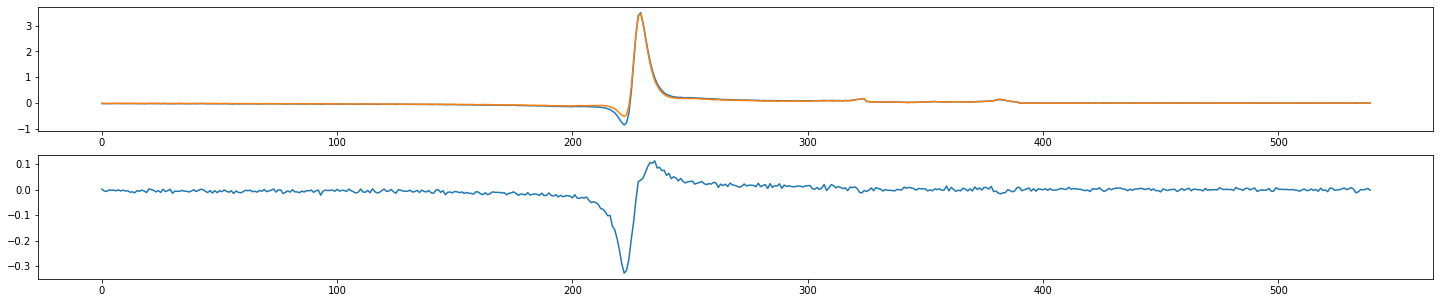

==== Epoch: 1/8 | train_loss = 0.050180499767884613 | train_p_correlation^2 = 0.9890294075012207
Training begins...


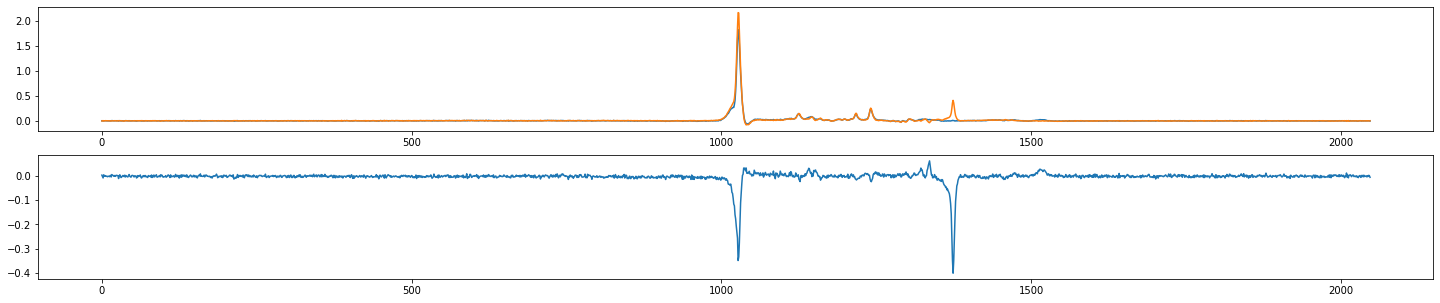

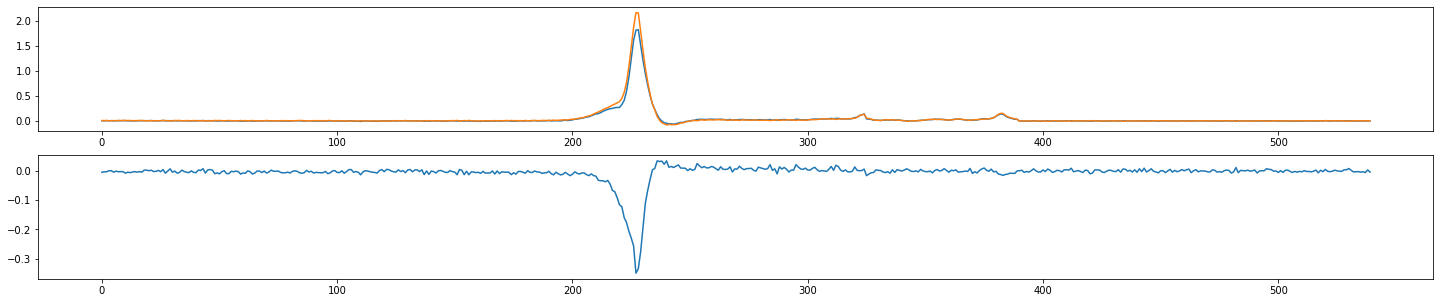

==== Epoch: 2/8 | train_loss = 0.03373575995210558 | train_p_correlation^2 = 0.9971421957015991
best model loss is 0.03373575995211 at epoch 2
Training begins...


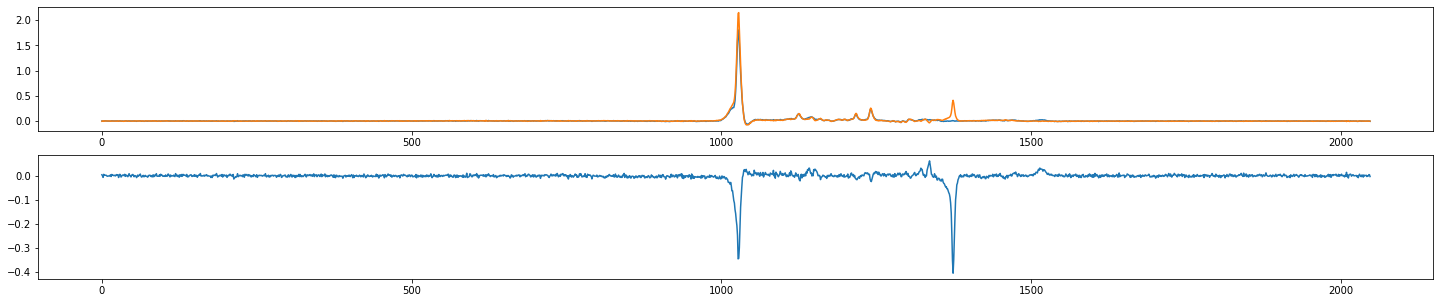

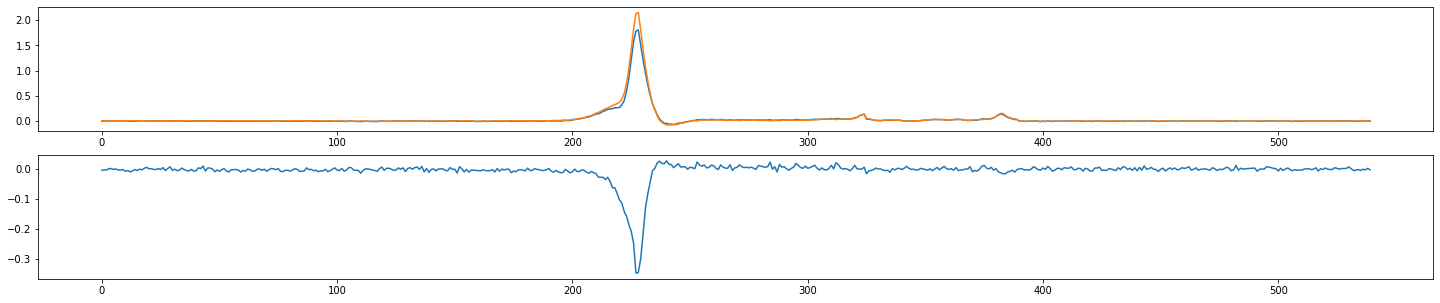

==== Epoch: 3/8 | train_loss = 0.032132815907243636 | train_p_correlation^2 = 0.9976179599761963
best model loss is 0.03213281590724 at epoch 3
Training begins...


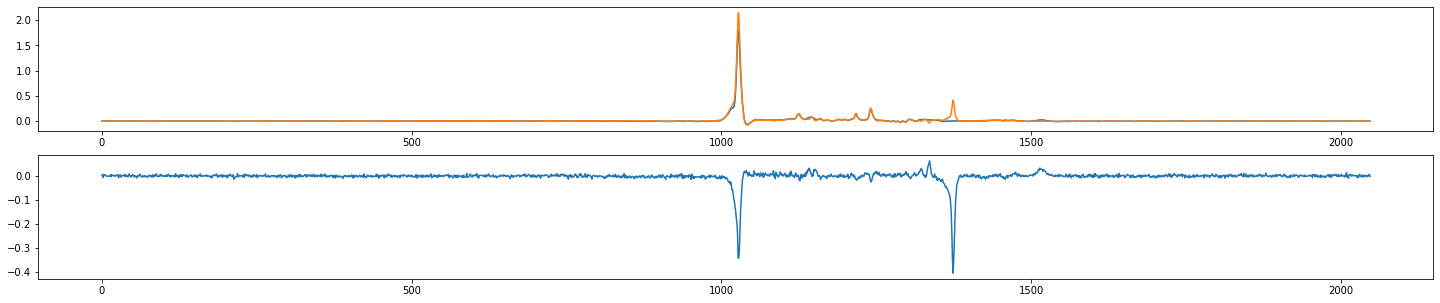

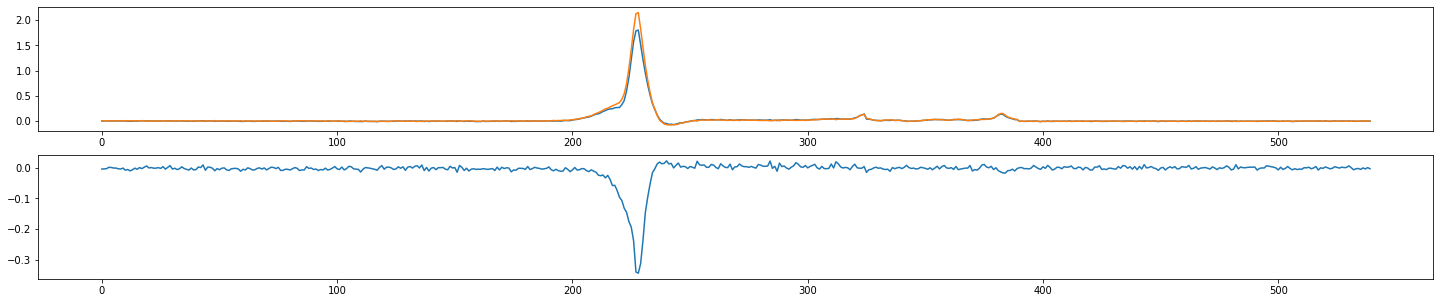

==== Epoch: 4/8 | train_loss = 0.03135231870692223 | train_p_correlation^2 = 0.9978013038635254
best model loss is 0.03135231870692 at epoch 4
Training begins...


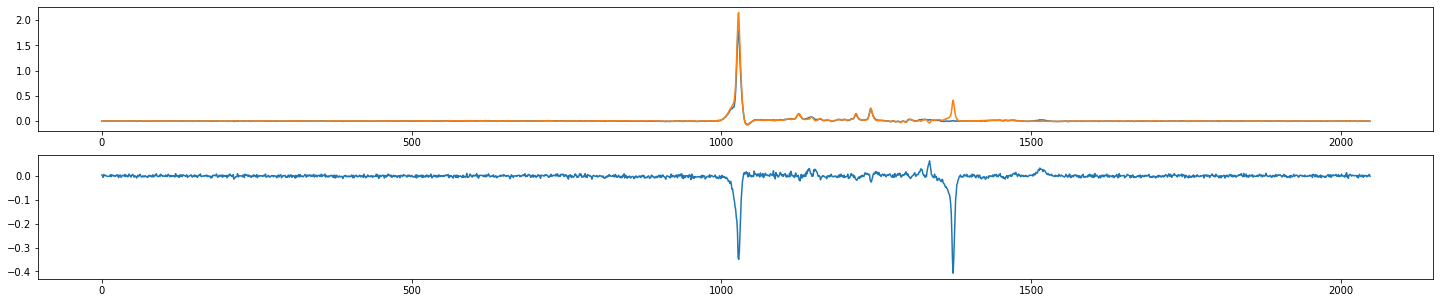

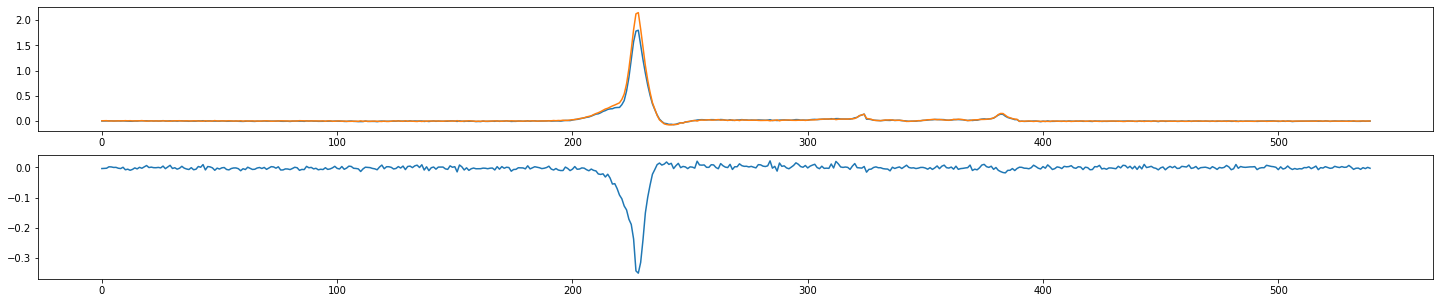

==== Epoch: 5/8 | train_loss = 0.030903666722588242 | train_p_correlation^2 = 0.9978808760643005
best model loss is 0.03090366672259 at epoch 5
Training begins...


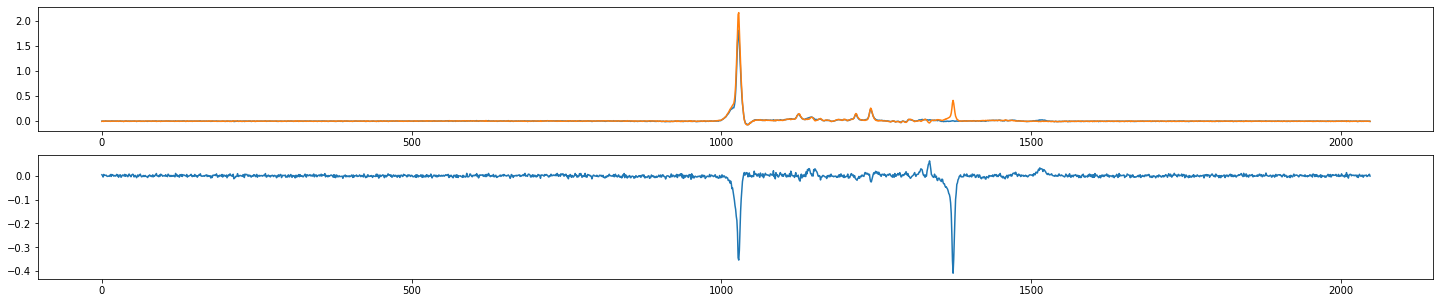

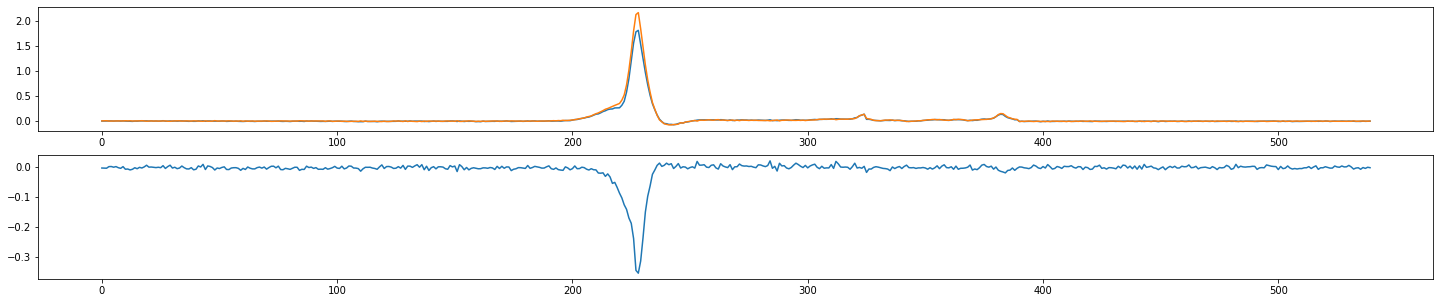

==== Epoch: 6/8 | train_loss = 0.030595546995755285 | train_p_correlation^2 = 0.9979312419891357
best model loss is 0.03059554699576 at epoch 6
Training begins...


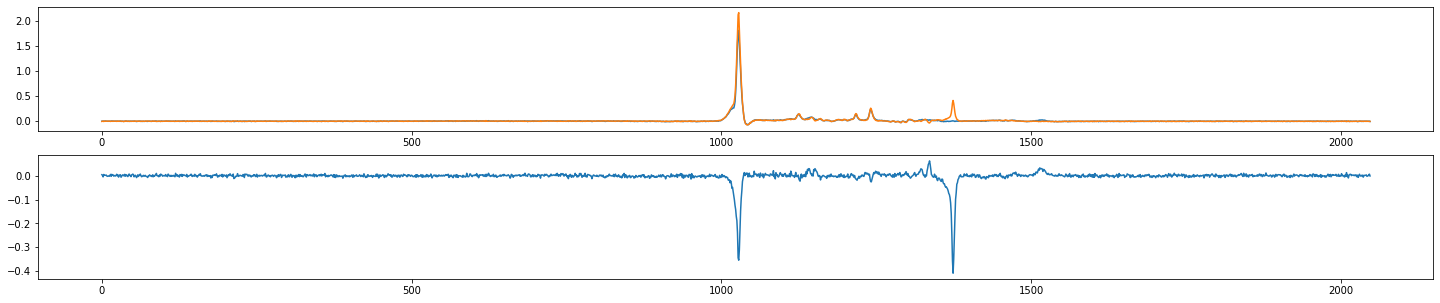

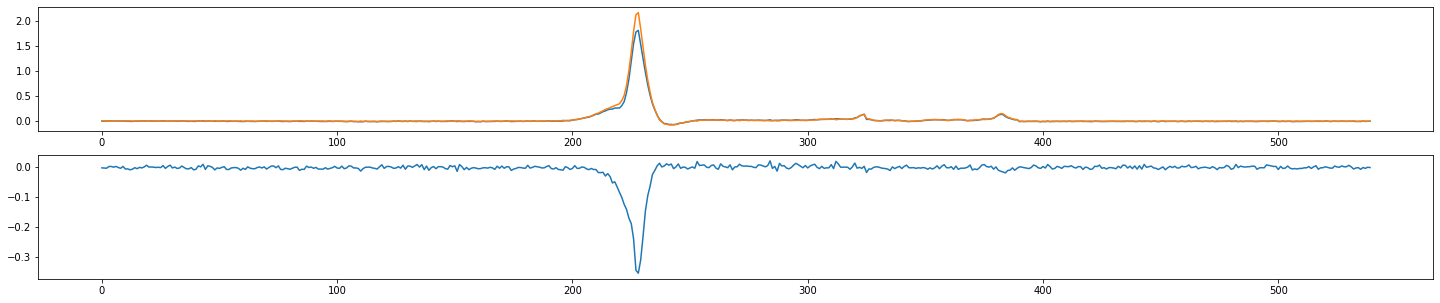

==== Epoch: 7/8 | train_loss = 0.030346070940140635 | train_p_correlation^2 = 0.9979662299156189
best model loss is 0.03034607094014 at epoch 7
Training begins...


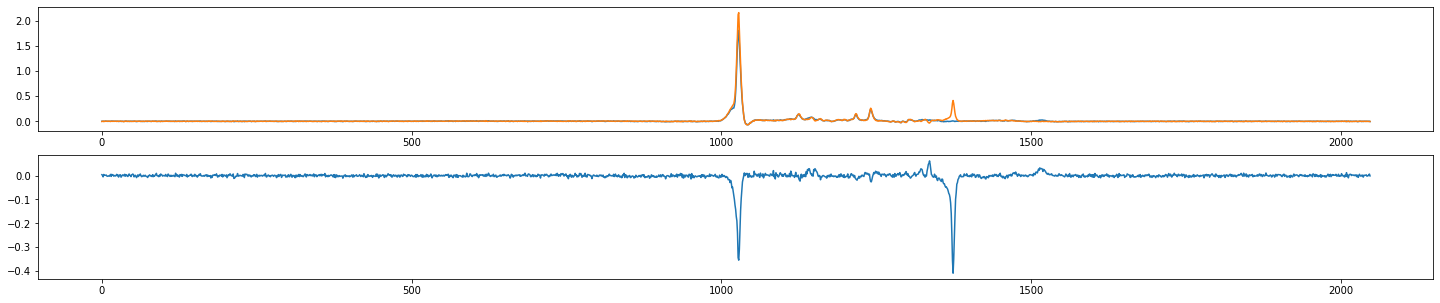

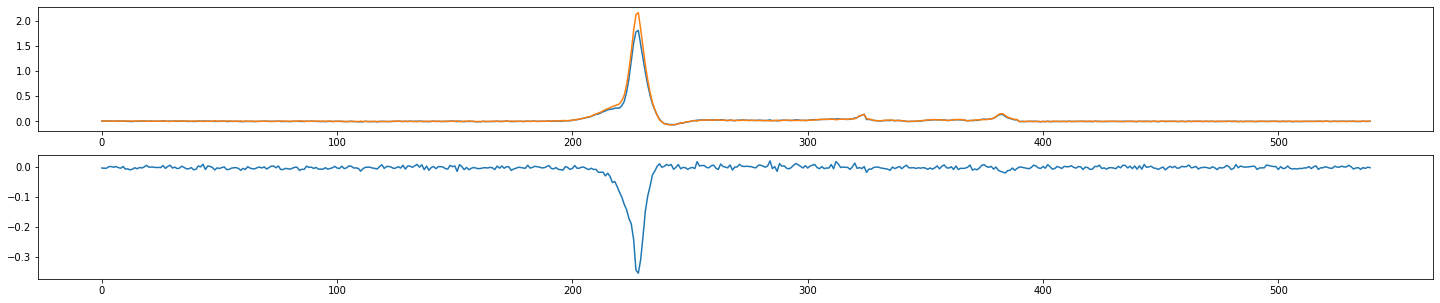

==== Epoch: 8/8 | train_loss = 0.03013643481535837 | train_p_correlation^2 = 0.9979931712150574
best model loss is 0.03013643481536 at epoch 8


In [22]:
# define the model

data_path='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/PH_SR_spectra_invivo_scripts'
best_JETSR_path= '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/PH_invivo_NoOffsets/ON_OFF_matching_rev_checkpoint_best.pt'
last_JETSR_path= '/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/PH_invivo_NoOffsets/ON_OFF_matching_rev_checkpoint_last.pt'
model_init='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/SR_spectra_3dB/checkpoint_best.pt'

OFFdata_dir='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/InVivo_scripts/DLSR/PH/Saved_spectra/NoOffset/Off_real_pred_spec'
ONdata_dir='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/InVivo_scripts/DLSR/PH/Saved_spectra/NoOffset/On_real_pred_spec'

JETSR = JETSR_L
JETSR.load_state_dict(torch.load(model_init))

# define loss and optimizer
criterion = L1Loss() 
criterion = SmoothL1Loss() 
criterion = MSELoss() 
lamda = 0.8
beta = 0.2

optimizer = Adam(JETSR.parameters(),lr=1e-4)

# define parameters
EPOCHS = 8

train_epoch_loss = []
train_epoch_F0_MAE = [] 
train_epoch_Phs_MAE = [] 
train_epoch_p_correlation = []

# early stopping
early_stop = 1
patience = 2
es_crit=0.0000001

# where to calculate the spectral loss
NR = 160

range1 = 800
range2 = 1100
range3 = 1100
range4 = 1700

Diff_range1 = 800
Diff_range2 = 1100
Diff_range3 = 1100
Diff_range4 = 1125
Diff_range5 = 1160
Diff_range6 = 1225
Diff_range7 = 1550
Diff_range8 = 1700

plot_range1=1050
plot_range2=1400

fid_range1 = 0
fid_range2 = 1024 
    
for epoch in range(EPOCHS):
     
    train_loss = []
    train_F0_MAE = [] 
    train_Phs_MAE = [] 
    train_p_correlation = []

    #######################################################
    ####################### Train #########################
    #######################################################
    
    ON_spectra_array=np.array([])
    OFF_spectra_array=np.array([])
    
    ON_spectra_array_SR_output=np.empty((160, 101, 2048))
    OFF_spectra_array_SR_output=np.empty((160, 101, 2048))
    
    ON_spectra_array_unaligned=np.empty((160, 101, 2048))
    OFF_spectra_array_unaligned=np.empty((160, 101, 2048))
    
    print('Training begins...')
    for batch_index, data in enumerate(train_loader):
        
        # If GPU is available, move the data to the GPU for faster computation.
        if cuda:
            
            # *** get the inputs; data is a list of [noisy_Real_spectUnAligned_tensor, Real_FidsAligned_tensor, Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor, time_mat_tensor, F0_tensor,Phs_tensor]
            Unaligned_aligned_spectra_tensor =  data[0].to(device)
            Real_FidsUnAligned_tensor, Imag_FidsUnAligned_tensor = data[1].to(device), data[2].to(device)
            Real_FidsAligned_tensor, Imag_FidsAligned_tensor=data[3].to(device), data[4].to(device)
            time_tensor, init_tensor = data[5].to(device), data[6].to(device) ##                        
            
            # *** Set the model to train mode ***
            JETSR.train()
            
            # *** zero the parameter gradients ***
            optimizer.zero_grad()
            
            # *** forward + backward + optimize ***
            
            #predict deformation from real spectra unaligned and aligned
            deformation_predicted = JETSR(Unaligned_aligned_spectra_tensor)
          
            #cloning real and imag fids unaligned tensor
            Real_FidsAligned_pred_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_FidsAligned_pred_tensor = torch.clone(Imag_FidsUnAligned_tensor)
            
            Real_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_pred_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Real_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)
            Imag_spec_tensor = torch.clone(Real_FidsUnAligned_tensor)       
            
            # *** Define loss between the real part of deformed spectra and the real part of the true spectra
            
            # cloning the ground truths (initializing)
            F0_pred_tensor = torch.clone(init_tensor)
            Phs_pred_tensor = torch.clone(init_tensor)
            
            for kk in range(len(deformation_predicted[:,0])):
                
                #introducing real deformations
                freqPart_real = torch.cos(-1 * time_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_real = torch.cos(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                #introducing imaginary deformations
                freqPart_imag = torch.sin(-1 * time_tensor[kk,:,:] * deformation_predicted[kk,0] * 2 * cm.pi)
                phasePart_imag = torch.sin(-1 * deformation_predicted[kk,1] * cm.pi / 180)
                
                #defining deformations from the offsets
                deformation_real = torch.mul(freqPart_real,phasePart_real) - torch.mul(freqPart_imag,phasePart_imag)
                deformation_imag = torch.mul(freqPart_real,phasePart_imag) + torch.mul(freqPart_imag,phasePart_real)
                
                #constructing tensor for the deformations
                F0_pred_tensor[kk] = deformation_predicted[kk,0] 
                Phs_pred_tensor[kk] = deformation_predicted[kk,1] 
                
                #contructing real and imaging fids prediction tensor
                Real_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_real
                                                                ) - torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_imag)
                Imag_FidsAligned_pred_tensor[kk,:,:] = torch.mul(Real_FidsUnAligned_tensor[kk,:,:],deformation_imag
                                                                ) + torch.mul(Imag_FidsUnAligned_tensor[kk,:,:],deformation_real)
                
                Real_pred_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                Imag_pred_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_pred_tensor[kk,:,:]+1j*Imag_FidsAligned_pred_tensor[kk,:,:])))
                
                Real_spec_tensor[kk,:,:] = torch.real(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
                Imag_spec_tensor[kk,:,:] = torch.imag(torch.fft.fftshift(torch.fft.fft(Real_FidsAligned_tensor[kk,:,:]+1j*Imag_FidsAligned_tensor[kk,:,:])))
            
            # ON and OFF specs
            Real_pred_spec_tensor_vector = torch.flatten(Real_pred_spec_tensor[:,:,np.concatenate([np.arange(range1,range2),np.arange(range3,range4)])])
            Real_spec_tensor_vector = torch.flatten(Real_spec_tensor[:,:,np.concatenate([np.arange(range1,range2),np.arange(range3,range4)])])
            
            Imag_pred_spec_tensor_vector = torch.flatten(Imag_pred_spec_tensor[:,:,np.concatenate([np.arange(range1,range2),np.arange(range3,range4)])])
            Imag_spec_tensor_vector = torch.flatten(Imag_spec_tensor[:,:,np.concatenate([np.arange(range1,range2),np.arange(range3,range4)])])
            
            Real_pred_spec_tensor_vector_sample = torch.flatten(Real_pred_spec_tensor[1,:,np.concatenate([np.arange(range1,range2),np.arange(range3,range4)])])
            Real_spec_tensor_vector_sample = torch.flatten(Real_spec_tensor[1,:,np.concatenate([np.arange(range1,range2),np.arange(range3,range4)])])
            
            Imag_pred_spec_tensor_vector_sample = torch.flatten(Imag_pred_spec_tensor[1,:,np.concatenate([np.arange(range1,range2),np.arange(range3,range4)])])
            Imag_spec_tensor_vector_sample = torch.flatten(Imag_spec_tensor[1,:,np.concatenate([np.arange(range1,range2),np.arange(range3,range4)])])
            
            # Diff specs of the corrected data
            Diff_Real_pred_spec_tensor_all = Real_pred_spec_tensor[101:,:,:]-Real_pred_spec_tensor[:101,:,:]
            Diff_Real_pred_spec_tensor_vector = torch.flatten(Diff_Real_pred_spec_tensor_all[:,:,np.concatenate([np.arange(Diff_range1,Diff_range2),np.arange(Diff_range3,Diff_range4),np.arange(Diff_range5,Diff_range6)])])
            
            Diff_Imag_pred_spec_tensor_all = Imag_pred_spec_tensor[101:,:,:]-Imag_pred_spec_tensor[:101,:,:]
            Diff_Imag_pred_spec_tensor_vector = torch.flatten(Diff_Imag_pred_spec_tensor_all[:,:,np.concatenate([np.arange(Diff_range1,Diff_range2),np.arange(Diff_range3,Diff_range4),np.arange(Diff_range5,Diff_range6)])])
            
            loss_Diff_spec_MAE_real = torch.mean(torch.abs(Diff_Real_pred_spec_tensor_vector))
            loss_Diff_spec_MAE_imag = torch.mean(torch.abs(Diff_Imag_pred_spec_tensor_vector))
            
            #check the Diff real spectra
            On_Real_pred_spec_tensor_vector_all_mean = np.squeeze(torch.mean(Real_pred_spec_tensor[101:,:,:],0).cpu().detach().numpy())
            Off_Real_pred_spec_tensor_vector_all_mean = np.squeeze(torch.mean(Real_pred_spec_tensor[:101,:,:],0).cpu().detach().numpy())
            Diff_Real_pred_spec_tensor_vector_all_mean = np.squeeze(torch.mean(Diff_Real_pred_spec_tensor_all,0).cpu().detach().numpy())
            if batch_index == 0:
                plt.figure(figsize=(25,5))
                plt.subplot(2,1,1)
                plt.plot(np.real(On_Real_pred_spec_tensor_vector_all_mean))
                plt.plot(np.real(Off_Real_pred_spec_tensor_vector_all_mean))
                
                plt.subplot(2,1,2)
                plt.plot(np.real(Diff_Real_pred_spec_tensor_vector_all_mean))
                
                plt.figure(figsize=(25,5))
                plt.subplot(2,1,1)
                
                plt.plot(np.real(On_Real_pred_spec_tensor_vector_all_mean[np.concatenate([np.arange(Diff_range1,Diff_range2),\
                                                                                            np.arange(Diff_range3,Diff_range4),\
                                                                                            np.arange(Diff_range5,Diff_range6),\
                                                                                         np.arange(Diff_range7,Diff_range8)])]))
                plt.plot(np.real(Off_Real_pred_spec_tensor_vector_all_mean[np.concatenate([np.arange(Diff_range1,Diff_range2),\
                                                                                            np.arange(Diff_range3,Diff_range4),\
                                                                                            np.arange(Diff_range5,Diff_range6),\
                                                                                          np.arange(Diff_range7,Diff_range8)])]))
                
                plt.subplot(2,1,2)
                
                plt.plot(np.real(Diff_Real_pred_spec_tensor_vector_all_mean[np.concatenate([np.arange(Diff_range1,Diff_range2),\
                                                                                            np.arange(Diff_range3,Diff_range4),\
                                                                                            np.arange(Diff_range5,Diff_range6),\
                                                                                           np.arange(Diff_range7,Diff_range8)])]))
                plt.show()
            
            #predicted and truth spectra loss computation
            loss_spec_MAE_real = criterion(Real_pred_spec_tensor_vector, Real_spec_tensor_vector) 
            loss_spec_MAE_imag = criterion(Imag_pred_spec_tensor_vector, Imag_spec_tensor_vector) 
            
            # spectra correlation loss real and imag
            t_Real_pred_spec = Real_pred_spec_tensor_vector - torch.mean(Real_pred_spec_tensor_vector)
            t_Real_spec = Real_spec_tensor_vector - torch.mean(Real_spec_tensor_vector)
            spec_p_correlation_real = torch.sum(t_Real_pred_spec * t_Real_spec) / (torch.sqrt(torch.sum(t_Real_pred_spec ** 2)) * torch.sqrt(torch.sum(t_Real_spec ** 2)))
            spec_loss_p_correlation_real = 1-torch.mul(spec_p_correlation_real,spec_p_correlation_real)
            t_Imag_pred_spec = Imag_pred_spec_tensor_vector - torch.mean(Imag_pred_spec_tensor_vector)
            t_Imag_spec = Imag_spec_tensor_vector - torch.mean(Imag_spec_tensor_vector)
            spec_p_correlation_imag = torch.sum(t_Imag_pred_spec * t_Imag_spec) / (torch.sqrt(torch.sum(t_Imag_pred_spec ** 2)) * torch.sqrt(torch.sum(t_Imag_spec ** 2)))
            spec_loss_p_correlation_imag = 1-torch.mul(spec_p_correlation_imag,spec_p_correlation_imag)
            
            if epoch <= EPOCHS:
                loss = loss_spec_MAE_real + loss_spec_MAE_imag + loss_Diff_spec_MAE_real #(lamda)*(loss_spec_MAE_real + loss_spec_MAE_imag)+(1-lamda)*(spec_loss_p_correlation_real + spec_loss_p_correlation_imag)
            else:
                loss = (lamda)*(loss_spec_MAE_real) + (beta)*(loss_Diff_spec_MAE_real) + (1-lamda-beta)*(spec_loss_p_correlation_real + spec_loss_p_correlation_imag)
            
            
            fid_pred_real = Real_FidsAligned_pred_tensor.cpu().detach().numpy()
            fid_pred_imag = Imag_FidsAligned_pred_tensor.cpu().detach().numpy()
            Real_pred_spec = np.real(fftshift(fft(fid_pred_real+1j*fid_pred_imag)))
            
            fid_unaligned_real = Real_FidsUnAligned_tensor.cpu().detach().numpy()
            fid_unaligned_imag = Imag_FidsUnAligned_tensor.cpu().detach().numpy()
            Real_unaligned_spec = np.real(fftshift(fft(fid_unaligned_real+1j*fid_unaligned_imag)))
            
            # compute the mean fids real and imag for each batch
            fid_pred_real_mean = torch.flatten(torch.mean(Real_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_real_mean = torch.flatten(torch.mean(Real_FidsAligned_tensor,0)).cpu().detach().numpy()
            fid_unaligned_real_mean = torch.flatten(torch.mean(Real_FidsUnAligned_tensor,0)).cpu().detach().numpy()
            
            fid_pred_imag_mean = torch.flatten(torch.mean(Imag_FidsAligned_pred_tensor,0)).cpu().detach().numpy()
            fid_imag_mean = torch.flatten(torch.mean(Imag_FidsAligned_tensor,0)).cpu().detach().numpy()
            fid_unaligned_imag_mean = torch.flatten(torch.mean(Imag_FidsUnAligned_tensor,0)).cpu().detach().numpy()
            
            #real spectra and predicted spectra for each batch
            Real_pred_spec_mean = np.real(fftshift(fft(fid_pred_real_mean+1j*fid_pred_imag_mean)))
            Real_spec_mean = np.real(fftshift(fft(fid_real_mean+1j*fid_imag_mean)))
            Real_unaligned_spec_mean = np.real(fftshift(fft(fid_unaligned_real_mean+1j*fid_unaligned_imag_mean)))
            
            
            r = spec_p_correlation_real.cpu().detach().numpy()
            p_correlation = r
    
            OFF_spectra_array_SR_output[batch_index,:,:]=np.squeeze(Real_pred_spec[:101,:,:]) # NR x 101 x 2048
            OFF_spectra_array_unaligned[batch_index,:,:]=np.squeeze(Real_unaligned_spec[:101,:,:]) # NR x 101 x 2048
            ON_spectra_array_SR_output[batch_index,:,:]=np.squeeze(Real_pred_spec[101:,:,:]) # NR x 101 x 2048
            ON_spectra_array_unaligned[batch_index,:,:]=np.squeeze(Real_unaligned_spec[101:,:,:])
                
            if batch_index==NR-1:
                np.save(OFFdata_dir+'PH_Off_real_pred_spec.npy', OFF_spectra_array_SR_output)
                np.save(ONdata_dir+'PH_On_real_pred_spec.npy', ON_spectra_array_SR_output)

            # backpropagate the loss
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # store the train_loss and tran_p_correlation
            train_loss.append(loss.cpu().data.item())
            train_p_correlation.append(p_correlation)
    
    train_epoch_loss.append(np.mean(train_loss))
    train_epoch_p_correlation.append(np.mean(train_p_correlation))

    print("==== Epoch: {}/{} | train_loss = {} | train_p_correlation^2 = {}".format(epoch+1, EPOCHS, train_epoch_loss[-1], \
                                                                                   train_epoch_p_correlation[-1]*train_epoch_p_correlation[-1])) 

    print("=======================================================================================================================")
    
    # Make sure we save the best and last unets.
    if epoch == 0:
        best_JETSR_loss = train_epoch_loss[0]
    if train_epoch_loss[-1] < best_JETSR_loss:
        best_JETSR_loss = train_epoch_loss[-1]
        best_epoch = epoch
        best_JETSR = JETSR.state_dict()
        print(f'best model loss is {best_JETSR_loss:0.14f} at epoch {epoch+1}' )
        torch.save(best_JETSR, best_JETSR_path)
    if (epoch == EPOCHS - 1):
        last_JETSR = JETSR.state_dict()
        torch.save(last_JETSR, last_JETSR_path)

    # Early stop 
    if (early_stop == 1):
        if (len(train_epoch_loss) > patience):
            if (np.min(train_epoch_loss[0:-patience+1]) <= es_crit):
                print('Training loss stop decreasing. Stop training.')
                last_JETSR = JETSR.state_dict()
                torch.save(last_JETSR, last_JETSR_path)
                break 
                
ON_spectra_array_unaligned=np.transpose(ON_spectra_array_unaligned,(2,0,1)) # 160NR, 101, 2048 -> 2048, 160NR, 101
OFF_spectra_array_unaligned=np.transpose(OFF_spectra_array_unaligned,(2,0,1))

ON_spectra_array_SR_output=np.transpose(ON_spectra_array_SR_output,(2,0,1))
OFF_spectra_array_SR_output=np.transpose(OFF_spectra_array_SR_output,(2,0,1))
DIFF_spectra_array_SR_output=ON_spectra_array_SR_output-OFF_spectra_array_SR_output

data_dir='/media/sail/Elements/JET_CNN/DL-FPC/MRS_SR_DL_scripts/InVivo_scripts/DLSR/PH/Saved_spectra/NoOffset/'
np.save(data_dir+'SR160_ON_OFF_Match_rev_'+'Diff_NoOffset.npy', DIFF_spectra_array_SR_output)
np.save(data_dir+'SR160_ON_OFF_Match_rev_'+'Off_NoOffset.npy', OFF_spectra_array_SR_output)
np.save(data_dir+'SR160_ON_OFF_Match_rev_'+'On_NoOffset.npy', ON_spectra_array_SR_output)


In [23]:
# saving data
diffDL = np.squeeze(np.mean(DIFF_spectra_array_SR_output[:,:,:], axis=1).real) 
offDL=np.squeeze(np.mean(OFF_spectra_array_SR_output[:,:,:], axis=1).real)
onDL=np.squeeze(np.mean(ON_spectra_array_SR_output[:,:,:], axis=1).real)

np.save(data_dir+'SR_ON_OFF_Match_'+'Diff_NoOffset.npy', diffDL)
np.save(data_dir+'SR_ON_OFF_Match_'+'Off_NoOffset.npy', offDL)
np.save(data_dir+'SR_ON_OFF_Match_'+'On_NoOffset.npy', onDL)